In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [3]:
X2_train = pd.read_csv('data/X2_train.csv')
X2_test = pd.read_csv('data/X2_test.csv')
y2_train = pd.read_csv('data/y2_train.csv')
y2_test = pd.read_csv('data/y2_test.csv')

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(4105, 18) (4105, 1) (410, 18) (410, 1) (4104, 18) (4104, 1) (410, 18) (410, 1)


In [5]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
###boosted ntrees (xg_boost)

In [6]:
results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X_train, y_train)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X_train, y_train.values.ravel())
        cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names.append(name)
    results.append(cv_results)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -0.797767 (0.628795)
KNN: -1.669319 (1.253311)
XGB: -1.460775 (1.113711)
RFR: -1.188712 (0.889926)


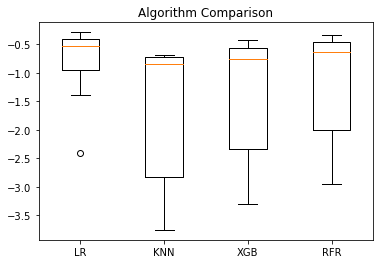

In [7]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

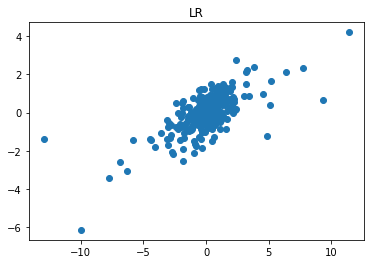

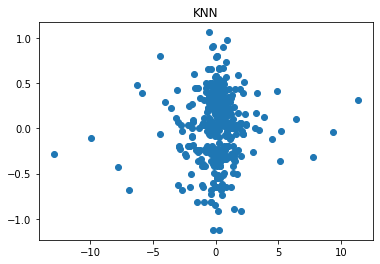

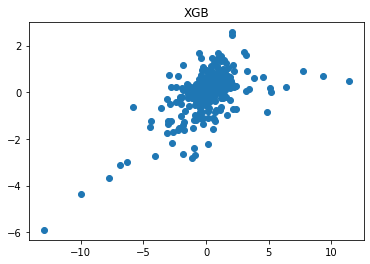

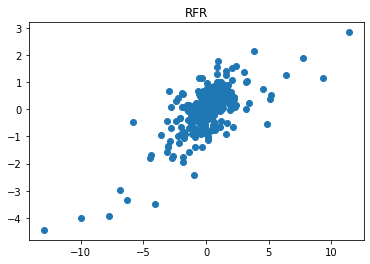

In [8]:
for i in range(len(models)):
    plt.figure()
    y_pred_LR = models[i][1].predict(X_test)
    plt.scatter(y_test, y_pred_LR)
    plt.title(models[i][0])
    plt.show()

Best Base Model so far seems to be random forrest regressor

In [9]:
for name, model in models:
    print(name, model.get_params())

LR {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
XGB {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
RFR {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity

In [10]:
param_search = {}
param_search['KNN'] = {'n_neighbors' : [1, 5, 10, 20, 50, 100, 200], 'leaf_size' : [5, 10, 20, 30, 50], 'n_jobs' :[-1]}
param_search['XGB'] = {'n_estimators' : [20, 50, 100, 200], 'base_score' : [0.5, 1.0, 2.0], 'learning_rate' : [0.2, 0.3, 0.5, 1.0], 'n_jobs' : [-1]}
param_search['RFR'] = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
tuned_results = []
tuned_best_score = []
tuned_best_estimator = []
for name, model in models:
    if name != 'LR':
        print(name)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search[name], scoring = 'neg_mean_squared_error')
        if name != 'RFR':
            gsearch.fit(X_train, y_train)
        else :
            gsearch.fit(X_train, y_train.values.ravel())
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        tuned_results.append(gsearch)
        tuned_best_score.append(best_score)
        tuned_best_estimator.append(best_model)
        print(best_score, best_model)

KNN
-1.2367414767293954 KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200)
XGB
-1.1476706434330874 XGBRegressor(base_score=2.0, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
RFR
-1.1164221749251129 RandomForestRegressor(n_estimators=50, n_jobs=-1)


In [16]:
for i in range(len(results)):
    print(names[i], results[i].mean())
#Print results in for loop to compare to tuned models

LR -0.7977670130085517
KNN -1.6693189335304575
XGB -1.4607752644613747
RFR -1.1887123006522695


In [31]:
for i in range(len(tuned_best_score)):
    print(tuned_best_estimator[i], tuned_best_score[i])

KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200) -1.2367414767293954
XGBRegressor(base_score=2.0, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) -1.1476706434330874
RandomForestRegressor(n_estimators=50, n_jobs=-1) -1.1164221749251129


In [ ]:
# min samples leaf, min samples split, max depth, criterion
# Score is mean squared error so do square root of positive version of that number.
# This shows accurate to within that value's percentage change.
#Linear Regression cannot be tuned